In [1]:
# coding: utf-8
% matplotlib inline
from __future__ import division
import tensorflow as tf
import numpy as np
import random
from collections import deque
from yahoo_finance import Share
import datetime
import matplotlib.pyplot as plt
import cv2
import time
import matplotlib.image as pimg

In [2]:
np.set_printoptions(threshold=np.inf)#print full array


In [3]:
day_len = 15   # how many days in each instance
stock = Share('2330.TW') #which stock to evaluate
today = datetime.date.today()
stock_data = stock.get_historical('2015-09-01','2016-08-24')
stock_data2 = stock.get_historical('2014-09-01', '2016-08-24')#set from 1 year before
print 'history data counts:' , len(stock_data)
stock_data.reverse() 
stock_data2.reverse() 
create_img='false' #test data existed? 

history data counts: 255


In [4]:
# remove empty data
def remove(stock_data):
    i = 0
    while( i < len(stock_data)):
        if (int(stock_data[i].get('Volume')) <= 0):
            stock_data.remove(stock_data[i])
            i = -1
        i += 1
    return stock_data

stock_data=remove(stock_data)
print 'after remove Volume is 0 :', len(stock_data)
stock_data2=remove(stock_data2)

after remove Volume is 0 : 239


## define each line, prepare to draw

In [5]:
yearline={}
monthline={}
seasonline={}

#def yearline()
year2011=len(stock_data)-len(stock_data2)
for i in xrange(0,len(stock_data)):
    year=0
    season=0
    month=0
    for j in xrange(0,year2011):
        year+=float(stock_data2[i+j].get('Close'))
    yearline[i]=float(year/year2011)
#def seasonline()
    for j in xrange(0,61):
        season+=float(stock_data2[year2011-61+i+j].get('Close'))
    seasonline[i]=float(season/61)
#def monthline()  
    for j in xrange(0,13):
        month+=float(stock_data2[year2011-13+i+j].get('Close'))
    monthline[i]=float(month/13)


In [6]:
my_train = np.zeros((len(stock_data)-day_len, day_len), dtype=np.float)
my_img= np.zeros((len(my_train),64,64), dtype=np.float)
new_img= np.zeros((len(my_train),64,64,2), dtype=np.float)
my_year = np.zeros((len(stock_data)-day_len, day_len), dtype=np.float)
year_img= np.zeros((len(my_train),64,64), dtype=np.float)
my_season = np.zeros((len(stock_data)-day_len, day_len), dtype=np.float)
my_month = np.zeros((len(stock_data)-day_len, day_len), dtype=np.float)

## Set training and testing data

In [7]:
for i in range(0, len(my_train)):
    for j in range(0, day_len):
        my_train[i,j] = float(stock_data[i+j].get('Close'))
        my_year[i,j] = yearline[i+j]
        my_month[i,j] = monthline[i+j]
        my_season[i,j] = seasonline[i+j]


label_test= np.zeros(len(my_train), dtype=np.float)

#set reward
earn=10
loss=-5
for x in xrange(0,len(my_train)):
    for y in xrange(0,500):# in the next 500 days reach 10 or-5
        if(x+y+1<len(my_train)):

            if((my_train[x+y+1][day_len-1]-my_train[x][day_len-1])/my_train[x][day_len-1]*100>earn):
                label_test[x]=my_train[x+y+1][day_len-1]-my_train[x][day_len-1]
                break
            elif((my_train[x+y+1][day_len-1]-my_train[x][day_len-1])/my_train[x][day_len-1]*100<loss):
                label_test[x]=my_train[x+y+1][day_len-1]-my_train[x][day_len-1]
                break
        else:
            label_test[x]=0
print("real label")            
print(label_test)

real label
[ 15.   15.5  14.   13.   13.   14.5  14.   14.   13.5  14.5  16.   15.
  -7.   14.5  14.5  -8.5  14.5  14.   -7.5  -7.   14.5  -8.5  -8.5  -7.5
  14.   14.5  14.5  14.5  -8.   -8.5  -7.5  -8.5  -9.   -8.   14.5  -7.
  15.   16.   -7.   14.   -7.5  -8.   -8.   -8.   -8.   -9.5  -7.5  -7.5
  -9.5  -9.5  -9.5  -7.5  -8.   -9.5  -7.5  -8.   -8.   -7.5  14.   -8.
  -9.5  -9.   -8.5  -9.   -8.5  -9.   -7.5  -8.   -9.   -9.5  -7.5  -8.
  14.   15.5  14.5  13.5  14.5  14.5  14.   14.5  14.   14.   14.   13.5
  16.   14.5  14.5  14.5  14.5  14.5  15.5  14.5  16.   15.5  15.   18.
  17.5  19.   19.   19.   16.   17.5  15.5  16.5  -8.   -9.   -8.   -8.5
  -8.   -8.   -9.   -8.5  -8.   -8.5  -8.5  -8.5  -8.5  -9.5 -10.   -8.5
  -9.5  -8.5  -8.   -9.   -9.   -8.5  -8.5  -8.5  -9.5  -8.5 -10.   -8.5
  -8.5  -8.5  -8.5  -9.5  -8.  -10.   -8.   -9.5  -9.  -10.   -8.   -9.
  -9.   15.5  18.   15.   18.   17.5  18.   15.   15.   15.   15.   14.5
  15.   15.   15.   17.   16.   19.   15.5  16

## draw image and load

In [8]:
def img_gray(my_img):
    new_img= np.zeros((64,64), dtype=np.float)
    for x in xrange(0,len(my_img)):
        for y in xrange(0,len(my_img[x])):
            if (my_img[x,y,0]!=1 and my_img[x,y,1]!=1):
                new_img[x,y]=0.7
            elif (my_img[x,y,0]!=1 and my_img[x,y,2]!=1):
                new_img[x,y]=0
            elif (my_img[x,y,1]!=1 and my_img[x,y,2]!=1):
                new_img[x,y]=0.35
            else:
                new_img[x,y]=1
    return new_img


def normalize(li):#a list for create image
    mean=sum(li) / float(len(li))
    for i in xrange(0,len(li)):
        li[i]=li[i]-mean
    return li
## yearline
if(create_img=='true'):
  #normalize
  for i in range(0, len(my_train)-1):
      my_train[i]=normalize(my_train[i])
      my_year[i]=normalize(my_year[i])	
      my_month[i]=normalize(my_month[i])	
      my_season[i]=normalize(my_season[i])	

  min_y=-6
  max_y=6
  print("axis y draw min "+str(min_y)+", max "+str(max_y))
  for x in xrange(0,len(my_year)):#save file
      #plt.figure()
      #print("saving pic:"+str(x))
      plt.plot(my_year[x],label='year_close',linewidth=5,color=[0,0,1])
      plt.plot(my_month[x],label='month_close',linewidth=5,color=[0,1,0])
      plt.plot(my_season[x],label='season_close',linewidth=5,color=[1,0,0])
      plt.axis([0, 14, min_y, max_y])
      plt.axis('off')
      plt.savefig('year_test/'+str(x)+'.png')
      plt.close()

for x in xrange(0,len(my_train)-day_len-1):#load file
    img = pimg.imread('year_test/'+str(x)+'.png')
    img2=cv2.resize(img,(64,64)) 
    my_img[x]=img_gray(img2)
    
##end yearline
my_test=my_img

## action and reward

In [9]:
class TWStock():
    def __init__(self, stock_data,label):
        self.stock_data = stock_data
        self.stock_index = 0
        self.label=label
    def render(self):
        # 尚未實作
        return 
    
    def reset(self):
        self.stock_index = 0
        return self.stock_data[self.stock_index]
    
    # 0: 觀望, 1: 持有多單, 2: 持有空單
    def step(self, action): 
        self.stock_index += 1

        action_reward=self.label[self.stock_index]
        if (action == 0):
            action_reward = 0

        #if (action == 2):
        #    action_reward = -1 * action_reward
        #print(str(action)+" "+str(action_reward))

        cv2.imshow('image',self.stock_data[self.stock_index])
        cv2.waitKey(1)

        stock_done = False
        if self.stock_index >= len(self.stock_data)-1:
            stock_done = True
        else:
            stock_done = False
        return self.stock_data[self.stock_index], action_reward, stock_done, 0


# DQN network define and agent

In [10]:
def conv2d(x, W,s):
  return tf.nn.conv2d(x, W, strides=[1, s,s,1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')



In [11]:
# Hyper Parameters for DQN
GAMMA = 0.9 # discount factor for target Q
INITIAL_EPSILON = 0.5 # starting value of epsilon
FINAL_EPSILON = 0.01 # final value of epsilon
REPLAY_SIZE = 10000 # experience replay buffer size
BATCH_SIZE = 32 # size of minibatch

class DQN():
  # DQN Agent
  def __init__(self, env):
    # init experience replay
    self.replay_buffer = deque()

    # init some parameters
    self.time_step = 0
    self.epsilon = INITIAL_EPSILON
    
    #self.state_dim = env.observation_space.shape[0]
    #self.action_dim = env.action_space.n
    
    self.state_dim = day_len
    self.action_dim = 2


    self.create_Q_network()
    self.create_training_method()

     # saving and loading networks
    self.saver = tf.train.Saver()
    self.session = tf.InteractiveSession()
    self.session.run(tf.initialize_all_variables())
    checkpoint = tf.train.get_checkpoint_state("saved_year_r")
    if checkpoint and checkpoint.model_checkpoint_path:
        self.saver.restore(self.session, checkpoint.model_checkpoint_path)
        print "Successfully loaded:", checkpoint.model_checkpoint_path
    else:
        print "Could not find old network weights"


  def create_Q_network(self):
    #-----------------------end cnn   start
         
        # network weights
    W_conv1 = self.weight_variable([8,8,1,32])
    b_conv1 = self.bias_variable([32])

    W_conv2 = self.weight_variable([4,4,32,64])
    b_conv2 = self.bias_variable([64])

    W_conv3 = self.weight_variable([3,3,64,64])
    b_conv3 = self.bias_variable([64])

    W_fc1 = self.weight_variable([1024,512])
    b_fc1 = self.bias_variable([512])

    W_fc2 = self.weight_variable([512,self.action_dim])
    b_fc2 = self.bias_variable([self.action_dim])

    # input layer

    self.state_input = tf.placeholder("float",[None,64,64])
    input1=tf.reshape(self.state_input,[-1,64,64,1])  

    # hidden layers
    h_conv1 = tf.nn.relu(conv2d(input1,W_conv1,4) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    h_conv2 = tf.nn.relu(conv2d(h_pool1,W_conv2,2) + b_conv2)

    h_conv3 = tf.nn.relu(conv2d(h_conv2,W_conv3,1) + b_conv3)
    h_conv3_shape = h_conv3.get_shape().as_list()
    print "dimension:",h_conv3_shape[1]*h_conv3_shape[2]*h_conv3_shape[3]
    h_conv3_flat = tf.reshape(h_conv3,[-1,1024])

    h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat,W_fc1) + b_fc1)

    # Q Value layer
    self.Q_value = tf.matmul(h_fc1,W_fc2) + b_fc2



  def create_training_method(self):
    self.action_input = tf.placeholder("float",[None,self.action_dim])
    # one hot presentation
    self.y_input = tf.placeholder("float",[None])
    Q_action = tf.reduce_sum(tf.mul(self.Q_value,self.action_input),reduction_indices = 1)
    self.cost = tf.reduce_mean(tf.square(self.y_input - Q_action))
    self.optimizer =  tf.train.RMSPropOptimizer(0.00025,0.99,0.0,1e-6).minimize(self.cost)



    
  def perceive(self,state,action,reward,next_state,done):
    one_hot_action = np.zeros(self.action_dim)
    one_hot_action[action] = 1
    self.replay_buffer.append((state,one_hot_action,reward,next_state,done))
    
    if len(self.replay_buffer) > REPLAY_SIZE:
      self.replay_buffer.popleft()

    if len(self.replay_buffer) > BATCH_SIZE:
      self.train_Q_network()

  def train_Q_network(self):
    self.time_step += 1

    # Step 1: obtain random minibatch from replay memory
    minibatch = random.sample(self.replay_buffer,BATCH_SIZE)
    state_batch = [data[0] for data in minibatch]
    action_batch = [data[1] for data in minibatch]
    reward_batch = [data[2] for data in minibatch]
    #print(reward_batch)
    next_state_batch = [data[3] for data in minibatch]
    # Step 2: calculate y
    y_batch = []
    Q_value_batch = self.Q_value.eval(feed_dict={self.state_input:next_state_batch})

    for i in range(0,BATCH_SIZE):
        done = minibatch[i][4]
        if done:
            y_batch.append(reward_batch[i])
        else :
            y_batch.append(reward_batch[i] + GAMMA * np.max(Q_value_batch[i]))
    self.optimizer.run(feed_dict={
      self.y_input:y_batch,
      self.action_input:action_batch,
      self.state_input:state_batch
      })

       
  def egreedy_action(self,state):
    Q_value = self.Q_value.eval(feed_dict = {
      self.state_input:[state]})[0]
    if random.random() <= self.epsilon:
      return random.randint(0,self.action_dim - 1)
    else:
      return np.argmax(Q_value)

    self.epsilon -= (INITIAL_EPSILON - FINAL_EPSILON)/10000


  def action(self,state):
    return np.argmax(self.Q_value.eval(feed_dict = {
      self.state_input:[state]})[0])


  def weight_variable(self,shape):
    initial = tf.truncated_normal(shape)
    return tf.Variable(initial)

  def bias_variable(self,shape):
    initial = tf.constant(0.01, shape = shape)
    return tf.Variable(initial)

## Main function

開始執行
dimension: 1024
Successfully loaded: saved_year_r/network-dqn-652000
Evaluation Total Reward: 182.0
[0.55 0.35 0.6 0.55 0.4 0.6 0.7 0.45 0.3 0.15 0.0]


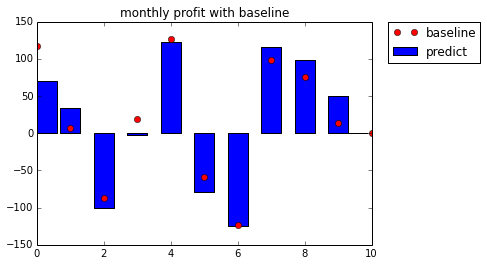

In [12]:
STEP = 1000   # Step limitation in an episode

def main():

 print '開始執行'


 out="test\n"     
 env1=TWStock(my_test,label_test)
 agent = DQN(env1)
 total_reward = 0
 month_reward=0
 state = env1.reset()
 p=0
 n=0
 month_arr={}
 buy_rate={}
 for j in xrange(STEP):

   env1.render()
   action = agent.action(state)   # direct action for test
   state,reward,done,_ = env1.step(action)
   out+=str(action)+" "+str(reward)+","
   if(reward>0):
      p+=1
   elif(reward<0):
      n+=1
   total_reward += reward
   month_reward += reward
   if((j % 20==0 )and( j!=0 )):
      #out+="\n"+"month_reward,correct,wrong : "+str(month_reward)+" "+str(p)+" "+str(n)+"\n\n"
      buy_rate=np.append(buy_rate,(p+n)/20)   
      p=0
      n=0
      month_arr=np.append(month_arr,month_reward)
 
      month_reward=0
   if done:
     break
 #print("correct,wrong ,rate : "+str(p)+" "+str(n)+" "+str(p/(p+n)))
 print 'Evaluation Total Reward:',total_reward
    
 label_line={}
 sum_=0
 for x in xrange(0,len(label_test)):
     sum_+=label_test[x]
     if(x % 20==0 and x!=0):
         label_line=np.append(label_line,sum_)
         sum_=0
 label_line=np.delete(label_line,0)
 month_arr=np.delete(month_arr,0)
 buy_rate=np.delete(buy_rate,0)
 for x in xrange(0,len(month_arr)):
        #month_arr[x]=month_arr[x]*buy_rate[x]
        label_line[x]=label_line[x]*buy_rate[x]
 print (buy_rate)
 plt.figure()
 plt.plot(label_line, 'ro',label='baseline',linewidth=1,color=[1,0,0])
 plt.title("monthly profit with baseline")
 #plt.plot(month_arr,label='predict',linewidth=5,color=[0,1,0])
 width = 0.6
 plt.bar([0,0.7,1.7,2.7,3.7,4.7,5.7,6.7,7.7,8.7,9.3],month_arr,width=width,label='predict')
 #plt.axis([0, 14, min_y, max_y])
 plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

 plt.show()

if __name__ == '__main__':
 main()